<a href="https://colab.research.google.com/github/kaiyang-code/intent-recognition-with-bert/blob/main/Intent_Recognition_with_BERT_using_Keras_and_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu >> /dev/null

In [ ]:
!pip install --upgrade grpcio >> /dev/null

ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.36.1 which is incompatible.
ERROR: tensorflow-gpu 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.36.1 which is incompatible.


In [ ]:
!pip install tqdm >> /dev/null

In [ ]:
!pip install bert-for-tf2 >> /dev/null

In [ ]:
!pip install sentencepiece >> /dev/null

In [ ]:
# provides funcitons for interacting with operating systems
import os
import math
import datetime

# tqdm is a pyhton library that allows you to output a small progress bar by wrapping around any iterable
from tqdm import tqdm

# pandas: for data manipulation and analysis
import pandas as pd
# numpy: support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np

# tensorflow: open-source library for machine learning
import tensorflow as tf
# Keras is an open-source software library that provides a Python interface for artificial neural networks
from tensorflow import keras

# bert: for natural language pre-training (it is pre-trained and was trained on wikipedia)
import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

# seaborn: high-level interface for drawing informative statistical graphics (based on matplotlib)
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

# matplotlib graphs will be included in the notebook, next to the code
%matplotlib inline
# any display with retina resolution will make the figure look better
%config InlineBackend.figure_format = 'retina'

sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.2)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)



In [ ]:
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 50.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 14.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: /content/test.csv
100% 43.1k/43.1k [00:00<00:00, 61.3MB/s]


In [ ]:
trian = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [ ]:
# append tehe valid dataframe into training dataframe and drop the index column
train = trian.append(valid).reset_index(drop = True)
train.shape

(13784, 2)

In [ ]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


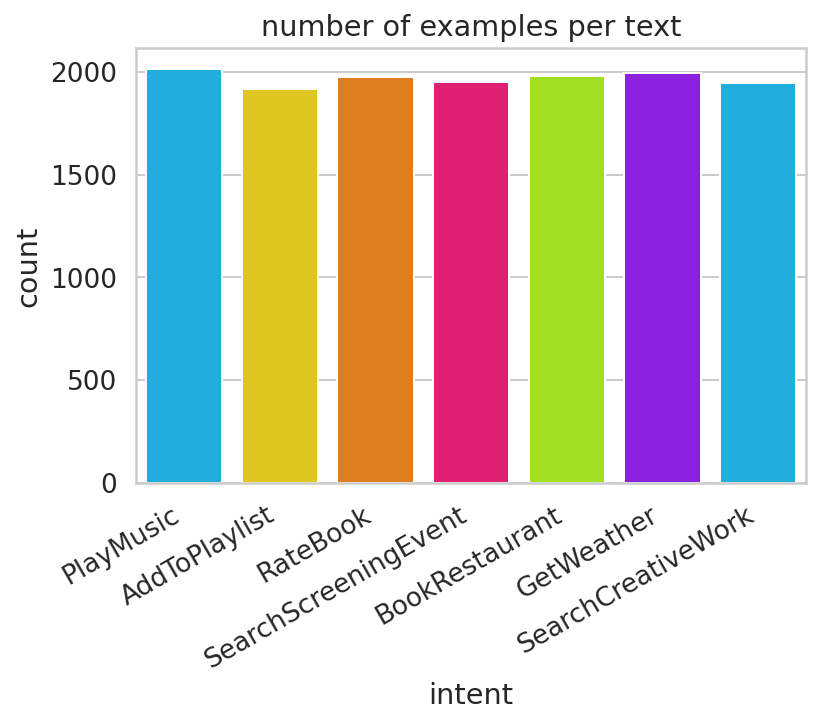

In [ ]:
RANDOM_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
# countplot is used to show the the counts of observations in each categorical bin using bars
chart = sns.countplot(train.intent, palette = RANDOM_PALETTE)
plt.title("number of examples per text")
# set the properties of the x-axis labels of the chart so that the labels don't overlap
chart.set_xticklabels(chart.get_xticklabels(), rotation = 30, horizontalalignment = 'right');

# Intent Recognition with BERT

In [ ]:
# wget is used to download contents from the internet
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2021-03-09 08:30:12--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 142.250.125.128, 74.125.129.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M   201MB/s    in 1.9s    

2021-03-09 08:30:14 (201 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]



In [ ]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
replace uncased_L-12_H-768_A-12/bert_model.ckpt.meta? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
replace uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
replace uncased_L-12_H-768_A-12/vocab.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
replace uncased_L-12_H-768_A-12/bert_model.ckpt.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
replace uncased_L-12_H-768_A-12/bert_config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
# make a new folder named 'model'
os.makedirs('model', exist_ok = True)

In [ ]:
# move the uncased folder into model
!mv uncased_L-12_H-768_A-12/ model

In [ ]:
bert_model_name = 'uncased_L-12_H-768_A-12'
# spcify the bert checkpoint directory
bert_ckpt_dir = os.path.join('model', bert_model_name)
# spcify the bert checkpoint file
bert_ckpt_file = os.path.join(bert_ckpt_dir, 'bert_model.ckpt')
# spcify the bert configuration file
bert_config_file = os.path.join(bert_ckpt_dir, 'bert_config.json')

## preprocssing

In [ ]:
trian.head()

In [ ]:
# summary:
# trian_x, test_x: a list of inner lists of the sizes max_seq_length; the inner list contains the token ids
# train_y, test_y: a list that contains the indexes of intents from 'classes'
# We figure out the padding length by taking the minimum between the longest text and the max sequence length parameter
class IntentDetectionData:

  DATA_COLUMN = 'text'
  LABEL_COLUNM = 'intent'

  # this 'classes' parameter is a list of different intents in this cases
  def __init__(self, train, test, tokenzier: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes

    # in this case, map() function takes in two iterables, which are 'train' and 'test' (all of their elements are of DataFrame type)
    # map() applies self._prepare() on each elements of 'train' and 'test' and returns two pairs of outputs: (train_x, train_y), (test_x, test_y)
    # in particular, all of the elements in 'train' will return to the (train_x, train_y) pair, and all of the elements in 'test' will return to the (test_x, test_y)
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [trian, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)

    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])



  def _prepare(self, df):
    x, y = [], []
    # for each row in the input DataFrame
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUNM]

      # tokenize the sentence
      tokens = self.tokenizer.tokenize(text)
      # we need to add "[CLS]" at the beginning of a sentence and "[SEP]" at the end of a sentence in order for BERT to understand
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      # in BERT, each word has its unqiue id, we are converting a list of tokens into a list of integers
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      
      self.max_seq_len = max(self.max_seq_len, len(token_ids))

      # x will be a list that contians lists of token_ids. For example: [[101, 2421, 112, 188], [3858, 1996, 3776, 106]]
      # y will be a list that contains the index of the intent in 'classes'
      x.append(token_ids)
      y.append(self.classes.index(label))
    # np.array takes less memory and runs faster; it also contains optimized and built-in functions 
    return np.array(x), np.array(y)

    

  def _pad(self, ids):
    x = []
    for input_ids in ids: 
      # max_seq_len - 2 because we need to get rid of the "[CLS]" and "[SEP]" ids
      cut_point = min(len(input_ids), self.max_seq_len - 2)
      # basically cut the input_ids from the start to the cut_point
      input_ids = input_ids[:cut_point]
      # if len(input_ids) < self.max_seq_len, fill the remaining rooms with zeros (the id for "[PAD]" is 0)
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [ ]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, 'vocab.txt'))

In [ ]:
tokenizer.tokenize("ha ha davis")

## fine-tuning

In [ ]:
# bert requires task specific fine-tuning
def create_model(max_seq_len, bert_config_file, bert_ckpt_file): 
  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
    # read data as json string
    customConfig = StockBertConfig.from_json_string(reader.read())
    # load all params for our model. If params not in customConfig, defauls value is used
    bert_params = map_stock_config_to_params(customConfig)

    # ???
    bert_params.adapter_size = None
    # Every layer does some multi-headed attention computation on the word representation of the previous layer to create a new intermediate representation. 
    # All these intermediate representations are of the same size.
    bert = BertModelLayer.from_params(bert_params, name = "bert")

  # shape: For instance, shape=(32,) indicates that the expected input will be batches of 32-dimensional vectors
  # dtype: The data type expected by the input
  input_ids = keras.layers.Input(shape = (max_seq_len, ), dtype = 'int32', name = "input_ids")

  bert_output = bert(input_ids)

  print("shape:", bert_output.shape) 

  # ????
  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)
  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))
  load_stock_weights(bert, bert_ckpt_file)
  return model



In [ ]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

In [ ]:
model = create_model(data.max_seq_len, bert_config_file, bert_ckpt_file)

In [ ]:
data.train_x.shape

In [ ]:
data.train_x[0]

In [ ]:
trian.text[0]

In [ ]:
model.summary()

In [108]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
model.fit(
  x=data.train_x,
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5
736/736 [==============================] - 5478s 7s/step - loss: 0.9728 - acc: 0.6415 - val_loss: 0.0592 - val_acc: 0.9817
Epoch 2/5
736/736 [==============================] - 5360s 7s/step - loss: 0.0426 - acc: 0.9888 - val_loss: 0.0483 - val_acc: 0.9893
Epoch 3/5
353/736 [=============>................] - ETA: 44:52 - loss: 0.0324 - acc: 0.9914

KeyboardInterrupt: ignored